# StreamPro – User Journey & Engagement Analysis

## Context

StreamPro is a video-streaming platform that has recently launched a new interactive feature.
The Product team wants to better understand how users move through the platform and where
engagement or conversion drops off.

This notebook demonstrates:
- How raw event data can be transformed into analytical models
- How to analyze user behavior across sessions
- How to answer key product questions using data

The focus is on **clarity of thinking, data modeling, and analytical reasoning**, rather than
production-grade infrastructure.

## Business Questions

The Product team is interested in answering the following questions:

**Q1.** What percentage of new users reach at least **30 seconds of watch time** in their **first session**?

**Q2.** Which **video genres** drive the highest **second-session retention within 3 days**?

**Q3.** Is there a particular **device OS or app version** where user drop-off is abnormally high?


## Data Sources

This analysis uses four input datasets:

### Event Logs (`events.jsonl`)
Event-level data capturing user interactions such as:
- session_start
- watch_time
- like / heart
- session_end

Each row represents a single event.

### Users (`users.csv`)
User-level dimension table containing:
- signup date
- subscription tier
- demographic attributes

### Videos (`videos.csv`)
Video-level metadata including:
- genre
- duration
- title

### Devices (`devices.csv`)
Device metadata used to analyze drop-offs by:
- device type
- OS version


## High-Level Pipeline Design

The data pipeline follows a simplified **Bronze → Silver → Gold** pattern.

**Bronze (Raw)**
- Raw JSON and CSV files
- Minimal transformation
- Schema-on-read

**Silver (Cleaned & Enriched)**
- Parsed timestamps and data types
- Event-level cleaning and validation
- Enriched with user, video, and device attributes

**Gold (Analytics Models)**
- Session-level aggregates
- First-session metrics
- Retention and drop-off indicators

This structure keeps raw data intact while enabling flexible analytical modeling.


## Key Assumptions & Definitions

- A **session** is identified by `session_id`
- Sessions may be missing explicit `session_start` or `session_end` events
- Session duration is inferred using first and last event timestamps
- `watch_time` events represent seconds watched and may occur multiple times per session
- A **new user** is defined as a user’s **first observed session**
- A **drop-off** is defined as a session with less than **10 seconds** of total watch time

## Pipeline Diagram


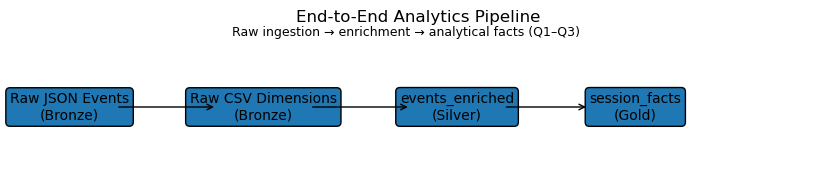

In [150]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis("off")

plt.suptitle(
    "Raw ingestion → enrichment → analytical facts (Q1–Q3)",
    fontsize=9,
    y=0.90
)

boxes = [
    ("Raw JSON Events\n(Bronze)", 0.05),
    ("Raw CSV Dimensions\n(Bronze)", 0.30),
    ("events_enriched\n(Silver)", 0.55),
    ("session_facts\n(Gold)", 0.78),
]

for text, x in boxes:
    ax.text(
        x, 0.5, text,
        ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.3"),
        fontsize=10
    )

for i in range(len(boxes) - 1):
    ax.annotate(
        "",
        xy=(boxes[i+1][1] - 0.06, 0.5),
        xytext=(boxes[i][1] + 0.06, 0.5),
        arrowprops=dict(arrowstyle="->")
    )

plt.title("End-to-End Analytics Pipeline", fontsize=12)
plt.show()


In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [3]:
DATA_DIR = Path("../Data")

EVENTS_PATH = DATA_DIR / "events.jsonl"
USERS_PATH = DATA_DIR / "users.csv"
VIDEOS_PATH = DATA_DIR / "videos.csv"
DEVICES_PATH = DATA_DIR / "devices.csv"

In [4]:
events_raw = pd.read_json(EVENTS_PATH, lines=True)
users_raw = pd.read_csv(USERS_PATH)
videos_raw = pd.read_csv(VIDEOS_PATH)
devices_raw = pd.read_csv(DEVICES_PATH)

In [16]:
#print("Events:", events_raw.shape)
#print("Users:", users_raw.shape)
#print("Videos:", videos_raw.shape)
#print("Devices:", devices_raw.shape)

In [33]:
#events_raw.info()
#users_raw.info()
#videos_raw.info()
#devices_raw.info()

In [137]:
#events_raw.head(10)
#users_raw.head()
#videos_raw.head()
#devices_raw.head()

## Clean & type raw data

In [17]:
events = events_raw.copy()
users = users_raw.copy()
videos = videos_raw.copy()
devices = devices_raw.copy()

In [18]:
events["timestamp"] = pd.to_datetime(events["timestamp"], errors="coerce")
users["signup_date"] = pd.to_datetime(users["signup_date"], errors="coerce")

In [20]:
#events["timestamp"].isna().sum()

In [21]:
events["event_name"] = events["event_name"].str.lower().str.strip()
events["device"] = events["device"].str.lower().str.strip()
events["device_os"] = events["device_os"].str.lower().str.strip()
events["network_type"] = events["network_type"].str.lower().str.strip()

In [22]:
events["value"] = pd.to_numeric(events["value"], errors="coerce")

invalid_watch_time = (
    (events["event_name"] == "watch_time") &
    ((events["value"].isna()) | (events["value"] < 0))
)

invalid_watch_time.sum()

0

In [23]:
events = events.dropna(subset=[
    "user_id",
    "session_id",
    "event_name",
    "timestamp"
])

In [24]:
events = events.sort_values(
    by=["user_id", "session_id", "timestamp"]
).reset_index(drop=True)

In [26]:
session_event_summary = (
    events
    .groupby("session_id")["event_name"]
    .value_counts()
    .unstack(fill_value=0)
)

session_event_summary.head()

event_name,heart,like,session_end,session_start,watch_time
session_id,,,,,
user_100_sess_0_0,2,4,1,1,7
user_100_sess_0_1,6,7,1,1,6
user_100_sess_1_0,6,6,1,1,3
user_100_sess_1_1,4,3,1,1,3
user_100_sess_2_0,2,1,1,1,5


In [28]:
events_with_videos = events.merge(
    videos[["video_id", "duration_seconds"]],
    on="video_id",
    how="left"
)

over_duration = (
    (events_with_videos["event_name"] == "watch_time") &
    (events_with_videos["value"] > events_with_videos["duration_seconds"])
)

over_duration.sum()

0

### Data Quality Summary

After basic validation:
- No invalid or negative watch_time values were found
- All watch_time values are within video duration bounds
- Sessions consistently contain exactly one session_start and session_end event

As a result, no corrective transformations were required beyond typing and normalization.


## Enrichment (joins with users, videos)

In [29]:
events_enriched = events.merge(
    users,
    on="user_id",
    how="left",
    validate="many_to_one"
)

In [30]:
events_enriched = events_enriched.merge(
    videos,
    on="video_id",
    how="left",
    validate="many_to_one"
)

In [40]:
#events_enriched.head(5)

,timestamp,account_id,video_id,user_id,event_name,value,device,app_version,device_os,network_type,ip,country,session_id,signup_date,subscription_tier,age_group,gender,title,genre,duration_seconds,patent_id
0,2025-04-18 04:47:00,account_3,video_14,user_1,session_start,NaN,mobile,1.5.9,ios,4g,192.168.75.172,CA,user_1_sess_0_0,2025-03-26,Free,36-50,Female,Video Title 14,Action,3507,patent_3
1,2025-04-18 04:47:05,account_2,video_18,user_1,like,NaN,tablet,1.1.2,ios,5g,192.168.209.143,DE,user_1_sess_0_0,2025-03-26,Free,36-50,Female,Video Title 18,Comedy,706,patent_2
2,2025-04-18 04:47:10,account_2,video_11,user_1,watch_time,2.0,tablet,2.8.1,ios,5g,192.168.211.154,DE,user_1_sess_0_0,2025-03-26,Free,36-50,Female,Video Title 11,Comedy,1710,patent_1
3,2025-04-18 04:47:15,account_5,video_9,user_1,heart,NaN,mobile,1.8.5,windows,5g,192.168.170.20,US,user_1_sess_0_0,2025-03-26,Free,36-50,Female,Video Title 9,Action,284,patent_4
4,2025-04-18 04:47:20,account_3,video_16,user_1,like,NaN,mobile,2.6.5,android,4g,192.168.37.27,DE,user_1_sess_0_0,2025-03-26,Free,36-50,Female,Video Title 16,Action,2924,patent_1


### Session level facts

In [48]:
session_facts = (
    events_enriched
    .groupby(["user_id", "session_id"])
    .agg(
        session_start_ts=("timestamp", "min"),
        session_end_ts=("timestamp", "max"),
        total_watch_seconds=("value", "sum"),
        had_heart=("event_name", lambda x: (x == "heart").any()),
        had_like=("event_name", lambda x: (x == "like").any()),
        device=("device", "first"),
        device_os=("device_os", "first"),
        app_version=("app_version", "first"),
        video_genre=("genre", "first")
    )
    .reset_index()
)

In [49]:
session_facts["session_duration_seconds"] = (
    session_facts["session_end_ts"] - session_facts["session_start_ts"]
).dt.total_seconds()

#session_facts[["session_duration_seconds", "total_watch_seconds"]].describe()

In [50]:
session_facts = session_facts.sort_values(
    by=["user_id", "session_start_ts"]
).reset_index(drop=True)

session_facts["session_number"] = (
    session_facts.groupby("user_id").cumcount() + 1
)

In [51]:
first_sessions = session_facts[session_facts["session_number"] == 1].copy()

#first_sessions.shape

In [52]:
session_facts["next_session_ts"] = (
    session_facts.groupby("user_id")["session_start_ts"].shift(-1)
)

session_facts["days_to_next_session"] = (
    session_facts["next_session_ts"] - session_facts["session_start_ts"]
).dt.days

In [53]:
session_facts["is_dropoff"] = session_facts["total_watch_seconds"] < 10
session_facts["reached_30s"] = session_facts["total_watch_seconds"] >= 30

In [54]:
session_facts.head()

,user_id,session_id,session_start_ts,session_end_ts,total_watch_seconds,had_heart,had_like,device,device_os,app_version,video_genre,session_duration_seconds,session_number,next_session_ts,days_to_next_session,is_dropoff,reached_30s
0,user_1,user_1_sess_0_0,2025-04-18 04:47:00,2025-04-18 04:48:20,21.0,True,True,mobile,ios,1.5.9,Action,80.0,1,2025-04-19 22:27:00,1.0,False,False
1,user_1,user_1_sess_1_0,2025-04-19 22:27:00,2025-04-19 22:27:55,10.0,True,True,tablet,ios,2.9.4,Comedy,55.0,2,2025-04-20 12:34:00,0.0,False,False
2,user_1,user_1_sess_2_0,2025-04-20 12:34:00,2025-04-20 12:34:55,2.0,True,True,tablet,windows,1.7.8,Comedy,55.0,3,2025-04-21 10:02:00,0.0,True,False
3,user_1,user_1_sess_3_0,2025-04-21 10:02:00,2025-04-21 10:02:35,8.0,True,True,mobile,android,1.2.2,Comedy,35.0,4,2025-04-21 18:58:00,0.0,True,False
4,user_1,user_1_sess_3_2,2025-04-21 18:58:00,2025-04-21 18:58:40,16.0,True,True,mobile,windows,2.0.6,Comedy,40.0,5,2025-04-21 19:07:00,0.0,False,False


##### event enriched: 
Event-level dataset with cleaned and parsed JSON events, enriched with user, device, OS, app version, and video metadata.
Grain: one row per event.
Used as the standardized input for all downstream analytics and aggregations.

##### session_facts
Session-level fact table derived from events_enriched.
Grain: one row per user per session.
Contains aggregated watch time, session ordering, time to next session, and engagement flags (is_dropoff, reached_30s) used to answer Q1–Q3.

## Visualization 

#### Q1 What % of new users reach at least 30 seconds of watch_time in their first session?

In [56]:
first_sessions = session_facts[session_facts["session_number"] == 1].copy()

In [57]:
q1_total_users = len(first_sessions)
q1_reached_30s = first_sessions["reached_30s"].sum()

q1_percentage = q1_reached_30s / q1_total_users * 100

q1_total_users, q1_reached_30s, round(q1_percentage, 2)

(100, 2, 2.0)

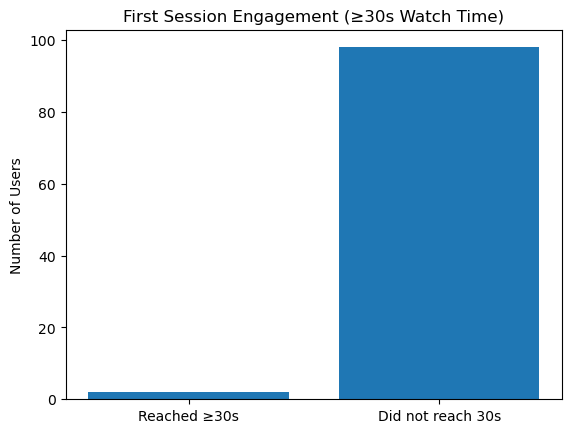

In [58]:
import matplotlib.pyplot as plt

labels = ["Reached ≥30s", "Did not reach 30s"]
values = [q1_reached_30s, q1_total_users - q1_reached_30s]

plt.figure()
plt.bar(labels, values)
plt.title("First Session Engagement (≥30s Watch Time)")
plt.ylabel("Number of Users")
plt.show()

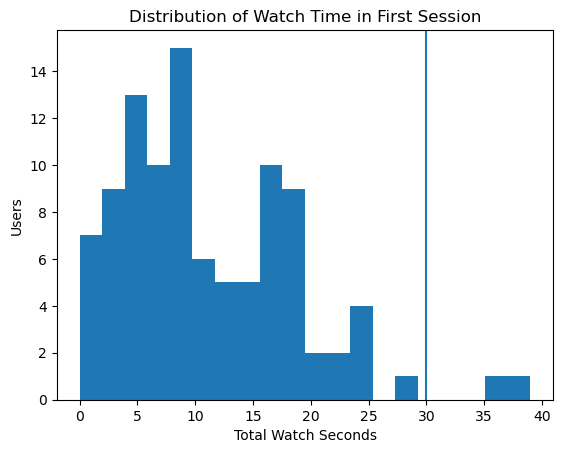

In [59]:
plt.figure()
plt.hist(first_sessions["total_watch_seconds"], bins=20)
plt.axvline(30)
plt.title("Distribution of Watch Time in First Session")
plt.xlabel("Total Watch Seconds")
plt.ylabel("Users")
plt.show()

#### Q2: Which video genres drive the highest 2nd-session retention within 3 days?

In [152]:
session_facts["retained_3d"] = (
    (session_facts["session_number"] == 1) &
    (session_facts["days_to_next_session"].notna()) &
    (session_facts["days_to_next_session"] <= 3)
)

In [153]:
genre_retention = (
    session_facts
    .query("session_number == 1")
    .groupby("video_genre")
    .agg(
        users=("user_id", "nunique"),
        retained_3d=("retained_3d", "sum")
    )
    .assign(retention_rate=lambda df: df["retained_3d"] / df["users"])
    .sort_values("retention_rate", ascending=False)
)

genre_retention

,users,retained_3d,retention_rate
video_genre,,,
Action,42,42,1.0
Comedy,22,22,1.0
Documentary,21,21,1.0
Drama,15,15,1.0


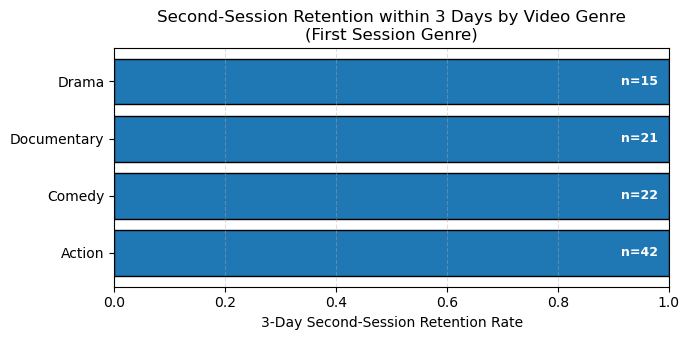

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3.5))

bars = plt.barh(
    genre_retention.index,
    genre_retention["retention_rate"],
    edgecolor="black"
)

# Annotate sample sizes
for bar, users in zip(bars, genre_retention["users"]):
    plt.text(
        bar.get_width() - 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"n={users}",
        va="center",
        ha="right",
        color="white",
        fontsize=9,
        fontweight="bold",
    )

plt.xlabel("3-Day Second-Session Retention Rate")
plt.title("Second-Session Retention within 3 Days by Video Genre\n(First Session Genre)")
plt.xlim(0, 1.0)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

#### Q3 Is there a particular device_os or app_version where drop-off is abnormally high?

In [96]:
os_dropoff = (
    first_sessions
    .assign(dropped=lambda df: df["total_watch_seconds"] < 30)
    .groupby("device_os")
    .agg(
        dropoff_pct=("dropped", lambda x: x.mean() * 100),
        users=("dropped", "size")
    )
    .reset_index()
    .sort_values("dropoff_pct", ascending=False)
)

os_dropoff

,device_os,dropoff_pct,users
2,windows,100.000000,47
1,ios,96.296296,27
0,android,96.153846,26


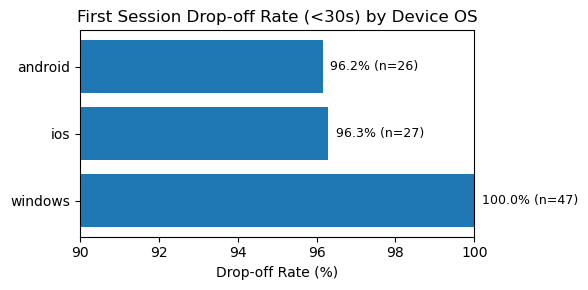

In [102]:
plt.figure(figsize=(6, 3))

bars = plt.barh(
    os_dropoff["device_os"],
    os_dropoff["dropoff_pct"]
)

plt.title("First Session Drop-off Rate (<30s) by Device OS")
plt.xlabel("Drop-off Rate (%)")
plt.xlim(90, 100)

# Annotate percentage + user count
for bar, (_, row) in zip(bars, os_dropoff.iterrows()):
    plt.text(
        bar.get_width() + 0.2,
        bar.get_y() + bar.get_height() / 2,
        f'{row["dropoff_pct"]:.1f}% (n={row["users"]})',
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [136]:
version_summary = (
    first_sessions
    .assign(reached_30s=first_sessions["total_watch_seconds"] >= 30)
    .groupby("app_version")
    .agg(
        users=("user_id", "size"),
        users_30s=("reached_30s", "sum")
    )
    .reset_index()
    .sort_values(["users_30s", "users"], ascending=False)
)

version_summary.head(10)


,app_version,users,users_30s
7,1.1.6,1,1
61,2.7.2,1,1
5,1.1.1,4,0
38,1.9.7,3,0
70,2.8.8,3,0
0,1.0.1,2,0
16,1.4.4,2,0
22,1.5.9,2,0
23,1.6.2,2,0
24,1.6.3,2,0


#####
Observation:
Engagement is uniformly low across app versions. With very few users reaching ≥30s and small sample sizes per version, there is no strong evidence that drop-off is driven by a specific app release.